# QSVM QOSF Task 4 – Quantum Support Vector Machine on Iris Dataset

**Author:** Boukabous Maria 
**Email:** mariaboukabous11@gmail.com
**Task:** QOSF Mentorship Screening – Task 4 (QSVM)  

---

### Objective
The notebook implements and compares two **Quantum Support Vector Machine (QSVM)** models on a binary classification problem using the Iris dataset.  

We explore:
- Data preprocessing and feature normalization
- Classical SVM baseline
- Two distinct QSVM circuits
- Decision boundaries and performance metrics
- Comparison between models

All plots and figures are saved in the `figures/` directory.


## Import Libraries

In [22]:
# ----- Classical ML & Data -----
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# ----- Quantum -----
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# ----- Utilities -----
import os
import pandas as pd
os.makedirs('figures', exist_ok=True)


## Load and Explore Data

 Data shape: (100, 2)
 Classes: [0 1]


,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
5,5.4,3.9,0
6,4.6,3.4,0
7,5.0,3.4,0
8,4.4,2.9,0
9,4.9,3.1,0


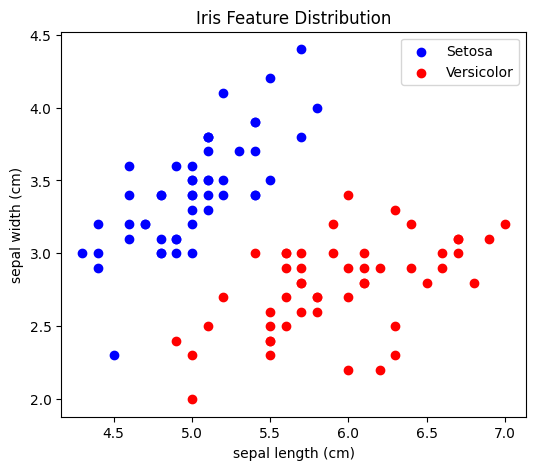

In [23]:
# ----- Load Iris dataset -----
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, :2]  # take first two features for visualization
Y = iris.target

# Keep only Setosa and Versicolor (binary classification)
mask = Y < 2
X = X[mask]
Y = Y[mask]

print(" Data shape:", X.shape)
print(" Classes:", np.unique(Y))

# ----- Display as table -----
feature_names = iris.feature_names[:2]  # first two features
df = pd.DataFrame(X, columns=feature_names)
df['target'] = Y
display(df.head(10))  # show first 10 rows

# ----- Scatter plot of features -----
plt.figure(figsize=(6,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='blue', label='Setosa')
plt.scatter(X[Y==1,0], X[Y==1,1], color='red', label='Versicolor')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Iris Feature Distribution")
plt.legend()
plt.savefig("figures/iris_distribution.png")
plt.show()


## Preprocessing

In [24]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

print(" Train shape:", x_train.shape, " Test shape:", x_test.shape)


 Train shape: (80, 2)  Test shape: (20, 2)


## Classical SVM Baseline

In [25]:
# Train classical SVM
clf = SVC(kernel='linear')
clf.fit(x_train, y_train)

# Predictions
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Accuracy
print(f"Classical SVM Train Accuracy: {accuracy_score(y_train, y_train_pred)*100:.2f}%")
print(f"Classical SVM Test Accuracy: {accuracy_score(y_test, y_test_pred)*100:.2f}%")

# Confusion matrices
print("Confusion matrix (train):\n", confusion_matrix(y_train, y_train_pred))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))


Classical SVM Train Accuracy: 98.75%
Classical SVM Test Accuracy: 100.00%
Confusion matrix (train):
 [[37  1]
 [ 0 42]]
Confusion matrix (test):
 [[12  0]
 [ 0  8]]


## Define QSVM Feature Map 1 (RY + CX)

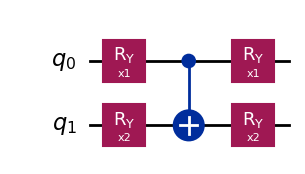

In [26]:
# Feature map 1
def feature_map_ry_cx():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    qc = QuantumCircuit(2)
    qc.ry(x1, 0)
    qc.ry(x2, 1)
    qc.cx(0,1)
    qc.ry(x1,0)
    qc.ry(x2,1)
    return qc

qc1 = feature_map_ry_cx()
qc1.draw('mpl')


## Train QSVM Model 1

In [27]:
# Quantum kernel
quantum_kernel_1 = FidelityQuantumKernel(feature_map=qc1)

# Compute kernel
print(" Computing training kernel for QSVM Model 1...")
kernel_train_1 = quantum_kernel_1.evaluate(x_vec=x_train, y_vec=x_train)

# Train SVM with precomputed kernel
qsvm_model_1 = SVC(kernel='precomputed')
qsvm_model_1.fit(kernel_train_1, y_train)
print(" QSVM Model 1 trained!")

# Train and Test predictions
y_train_pred_q1 = qsvm_model_1.predict(kernel_train_1)
kernel_test_1 = quantum_kernel_1.evaluate(x_vec=x_test, y_vec=x_train)
y_test_pred_q1 = qsvm_model_1.predict(kernel_test_1)

# Accuracy
train_acc_q1 = accuracy_score(y_train, y_train_pred_q1)
test_acc_q1 = accuracy_score(y_test, y_test_pred_q1)
print(f"QSVM Model 1 Train Accuracy: {train_acc_q1*100:.2f}%")
print(f"QSVM Model 1 Test Accuracy: {test_acc_q1*100:.2f}%")


 Computing training kernel for QSVM Model 1...
 QSVM Model 1 trained!
QSVM Model 1 Train Accuracy: 91.25%
QSVM Model 1 Test Accuracy: 85.00%


## QSVM Model 2 (RZ + CX + Layered)

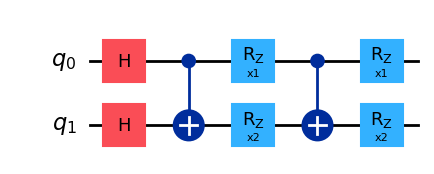

In [28]:
def feature_map_rz_cx_layers():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    qc = QuantumCircuit(2)
    qc.h([0,1])
    qc.cx(0,1)
    qc.rz(x1,0)
    qc.rz(x2,1)
    qc.cx(0,1)
    qc.rz(x1,0)
    qc.rz(x2,1)
    return qc

qc2 = feature_map_rz_cx_layers()
qc2.draw('mpl')


## Train QSVM Model 2

In [29]:
quantum_kernel_2 = FidelityQuantumKernel(feature_map=qc2)

print(" Computing training kernel for QSVM Model 2...")
kernel_train_2 = quantum_kernel_2.evaluate(x_vec=x_train, y_vec=x_train)

qsvm_model_2 = SVC(kernel='precomputed')
qsvm_model_2.fit(kernel_train_2, y_train)

# Predictions
y_train_pred_q2 = qsvm_model_2.predict(kernel_train_2)
kernel_test_2 = quantum_kernel_2.evaluate(x_vec=x_test, y_vec=x_train)
y_test_pred_q2 = qsvm_model_2.predict(kernel_test_2)

# Accuracy
train_acc_q2 = accuracy_score(y_train, y_train_pred_q2)
test_acc_q2 = accuracy_score(y_test, y_test_pred_q2)
print(f"QSVM Model 2 Train Accuracy: {train_acc_q2*100:.2f}%")
print(f"QSVM Model 2 Test Accuracy: {test_acc_q2*100:.2f}%")


 Computing training kernel for QSVM Model 2...
QSVM Model 2 Train Accuracy: 81.25%
QSVM Model 2 Test Accuracy: 85.00%


## Plot Decision Boundaries

In [30]:
from sklearn.metrics.pairwise import rbf_kernel

def fast_plot_decision_boundary(model, x_data, y_data, x_train_ref, title, save_path):
    xx, yy = np.meshgrid(
        np.linspace(x_data[:,0].min()-1, x_data[:,0].max()+1, 40),
        np.linspace(x_data[:,1].min()-1, x_data[:,1].max()+1, 40)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Approximate quantum kernel with a classical RBF kernel (for visualization only)
    kernel_grid = rbf_kernel(grid_points, x_train_ref, gamma=0.5)

    Z = model.predict(kernel_grid).reshape(xx.shape)
    
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdBu")
    plt.scatter(x_data[y_data==0,0], x_data[y_data==0,1], color='blue', label='Setosa')
    plt.scatter(x_data[y_data==1,0], x_data[y_data==1,1], color='red', label='Versicolor')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.savefig(save_path)
    plt.show()


## Compare Model Performance

In [31]:
from sklearn.metrics.pairwise import rbf_kernel

def fast_plot_decision_boundary(model, x_data, y_data, x_train_ref, title, save_path):
    xx, yy = np.meshgrid(
        np.linspace(x_data[:,0].min()-1, x_data[:,0].max()+1, 40),
        np.linspace(x_data[:,1].min()-1, x_data[:,1].max()+1, 40)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Approximate quantum kernel with a classical RBF kernel (for visualization only)
    kernel_grid = rbf_kernel(grid_points, x_train_ref, gamma=0.5)

    Z = model.predict(kernel_grid).reshape(xx.shape)
    
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdBu")
    plt.scatter(x_data[y_data==0,0], x_data[y_data==0,1], color='blue', label='Setosa')
    plt.scatter(x_data[y_data==1,0], x_data[y_data==1,1], color='red', label='Versicolor')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.savefig(save_path)
    plt.show()



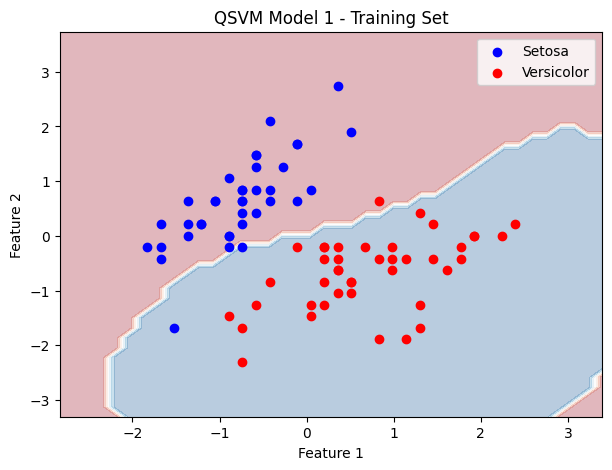

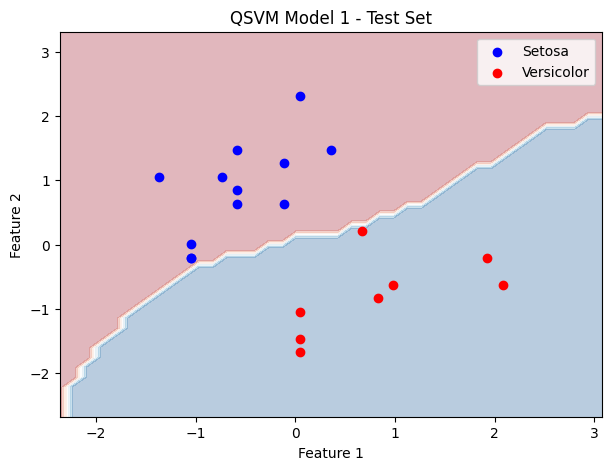

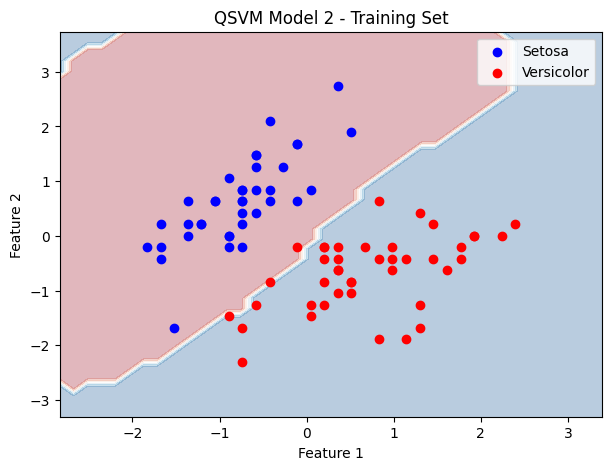

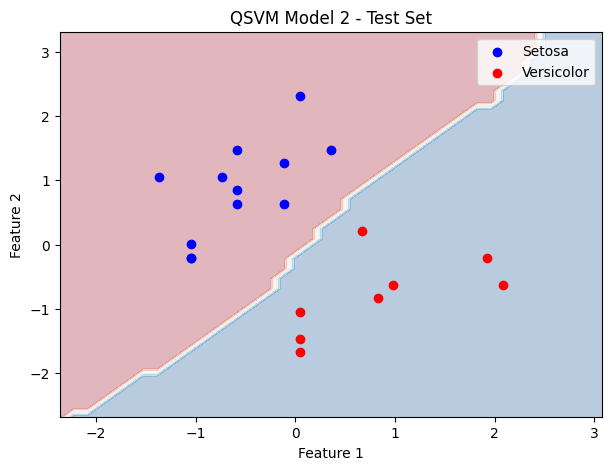

In [32]:

fast_plot_decision_boundary(qsvm_model_1, x_train, y_train, x_train,
                            "QSVM Model 1 - Training Set", "figures/qsvm1_train_fast.png")

fast_plot_decision_boundary(qsvm_model_1, x_test, y_test, x_train,
                            "QSVM Model 1 - Test Set", "figures/qsvm1_test_fast.png")

fast_plot_decision_boundary(qsvm_model_2, x_train, y_train, x_train,
                            "QSVM Model 2 - Training Set", "figures/qsvm2_train_fast.png")
fast_plot_decision_boundary(qsvm_model_2, x_test, y_test, x_train,
                            "QSVM Model 2 - Test Set", "figures/qsvm2_test_fast.png")



## Performance Comparison Plot

In [33]:
import pandas as pd

# Comparison table
df = pd.DataFrame({
    'Model': ['QSVM Model 1', 'QSVM Model 2', 'Classical SVM'],
    'Train Accuracy': [train_acc_q1, train_acc_q2, accuracy_score(y_train, y_train_pred)],
    'Test Accuracy': [test_acc_q1, test_acc_q2, accuracy_score(y_test, y_test_pred)]
})

df['Train Accuracy (%)'] = df['Train Accuracy']*100
df['Test Accuracy (%)'] = df['Test Accuracy']*100
df = df.drop(['Train Accuracy','Test Accuracy'], axis=1)
df



,Model,Train Accuracy (%),Test Accuracy (%)
0,QSVM Model 1,91.25,85.0
1,QSVM Model 2,81.25,85.0
2,Classical SVM,98.75,100.0


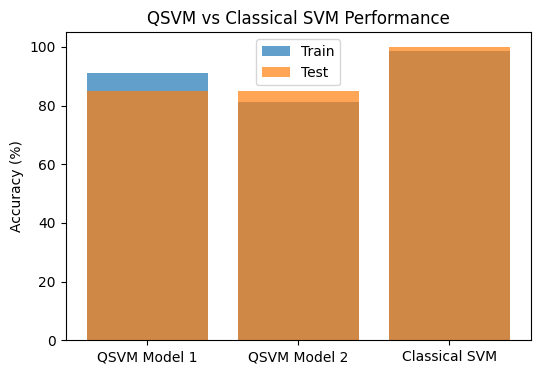

In [34]:
plt.figure(figsize=(6,4))
plt.bar(df['Model'], [train_acc_q1*100, train_acc_q2*100, accuracy_score(y_train, y_train_pred)*100], alpha=0.7, label='Train')
plt.bar(df['Model'], [test_acc_q1*100, test_acc_q2*100, accuracy_score(y_test, y_test_pred)*100], alpha=0.7, label='Test')
plt.ylabel("Accuracy (%)")
plt.title("QSVM vs Classical SVM Performance")
plt.legend()
plt.savefig("figures/performance_comparison.png")
plt.show()


##  Import Project Modules

To keep the project modular and well-organized, all core functionalities are divided across separate Python scripts inside the `src/` folder.

Each module handles a specific part of the QSVM workflow:

| Module | Description |
|---------|--------------|
| **`data_preprocessing.py`** | Handles dataset loading, binary filtering (Setosa vs. Versicolor), normalization, splitting, and visualization. |
| **`qsvm_models.py`** | Contains definitions for quantum and classical models, quantum kernel setup, and training/evaluation functions. |
| **`utils.py`** | Provides utility functions for plotting decision boundaries, comparing model performance, and general helpers. |

These modules are imported below for use throughout the notebook:


In [35]:
from src.data_preprocessing import load_iris_binary, prepare_data, visualize_data, display_sample
from src.qsvm_models import qsvm_model_1, qsvm_model_2, train_qsvm, evaluate_qsvm, classical_svm
from src.utils import plot_decision_boundary, compare_performance
